# Project: Investigate movie trends  

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this investigation, We'll use the a database from The Movie Database (TMDb). We're looking for what kind of properties a movie needs to be very profit in the actual world.

Some of the properties we're looking for:
- Genres
- Runtime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

As a first step, we'll load the data and We'll get a preview of it 

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


Size of the dataframe

In [3]:
df.shape

(10866, 21)

Taking a look in the preview, We can see some problems, there are important data for us, like `genres`, that are contained in the same column, the columns `budget_adj` and `revenue_adj` have a unsual format (scientific notation) that could give use some not exact results at the moment of operate it and there are some missing data, like `gross_profit`, that we could calculate, but it's a good idea have a column for it.
Now we'll see the types into the data 

In [4]:
df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

Now, We can see that there are more than one unuseless columns for us in our dataframe, like ids, homepage, `budget` and `revenue` (We'll use their adjusted version).

Looking for missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Data Cleaning (Replace this with more specific notes!)

In [6]:
# As first step, let's drop all the useless columns in the dataframe
useless_columns = ['id', 'imdb_id', 'budget', 'revenue', 'cast', 'homepage', 'tagline', 'keywords', 'overview', 'vote_count']
df.drop(useless_columns, axis=1, inplace = True)
df.head(1)

,popularity,original_title,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,6.5,2015,1.379999e+08,1.392446e+09


Now We can remove the '_adj' from the columns

In [7]:
df.rename(columns = {'budget_adj': 'budget', 'revenue_adj': 'revenue'}, inplace = True)
df.head(1)

,popularity,original_title,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget,revenue
0,32.985763,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,6.5,2015,1.379999e+08,1.392446e+09


Now, We can change their type from `float` to `int`

In [8]:
df['budget'] = df['budget'].astype(int)
df['revenue'] = df['revenue'].astype(int)
df.head(1)

,popularity,original_title,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget,revenue
0,32.985763,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,6.5,2015,137999939,1392445892


Now we need separate all the genres movies,the column genres have some missing values, to fill all those values We'll use a new genre, 'Generic' 

In [11]:
df['genres'].fillna('Generic', inplace=True)

In [12]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df
df_mg = splitDataFrameList(df, 'genres', "|")
df_mg.head()

,budget,director,genres,original_title,popularity,production_companies,release_date,release_year,revenue,runtime,vote_average
0,137999939,Colin Trevorrow,Action,Jurassic World,32.985763,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,2015,1392445892,124,6.5
1,137999939,Colin Trevorrow,Adventure,Jurassic World,32.985763,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,2015,1392445892,124,6.5
2,137999939,Colin Trevorrow,Science Fiction,Jurassic World,32.985763,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,2015,1392445892,124,6.5
3,137999939,Colin Trevorrow,Thriller,Jurassic World,32.985763,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,2015,1392445892,124,6.5
4,137999939,George Miller,Action,Mad Max: Fury Road,28.419936,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,2015,348161292,120,7.1


<a id='eda'></a>
## Exploratory Data Analysis

As a first step let's find the most popular movie genres in the last few years
### Most popular movie genres in the last 3 years

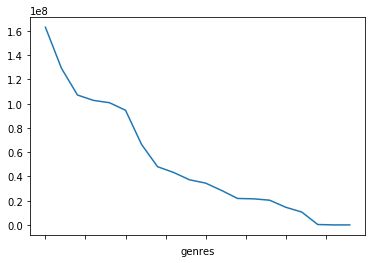

In [41]:
df_last = df_mg.query('release_year > 2012').copy()
grouped = df_last.groupby('genres').mean().sort_values('revenue', ascending=False)

### Research Question 2: Are there a relation between the profit and the its score?

In the following chart, We can observe that the movie with more profits usually have better scores

In [24]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
plot_2 = df_profit.query('profit_margin > 0').plot(x='profit_margin', y='vote_average', kind='scatter')

NameError: name 'df_profit' is not defined

### Research Question 3: In the last 5 years, How movie trends have changed?

In [ ]:

df_mg_11 = df_mg.query('release_year == 2011')
df_mg_12 = df_mg.query('release_year == 2012')
df_mg_13 = df_mg.query('release_year == 2013')
df_mg_14 = df_mg.query('release_year == 2014')
df_mg_15 = df_mg.query('release_year == 2015')

newdf = pd.DataFrame()

df_mg['genres'].plot(kind='bar')

#newdf['2011'] = df_mg_11.groupby('genres')['popularity'].mean()
#newdf['2012'] = df_mg_12.groupby('genres')['popularity'].mean()
#newdf['2013'] = df_mg_13.groupby('genres')['popularity'].mean()
#newdf['2014'] = df_mg_14.groupby('genres')['popularity'].mean()
#newdf['2015'] = df_mg_15.groupby('genres')['popularity'].mean()

#newdf.plot()

### How has movie runtime changed